# Шавель 853501 Лабораторная работа № 3

Вариант 25. Имеется одноканальная СМО с очередью, ограниченной числом мест R = 2. На вход СМО поступает простейший по ток заявок с интенсивностью X. Время обслуживания распределено по обобщенному закону Эрланга с параметрами k, X2. Найти вероятности состояний СМО и характеристики эффективности СМО.

По сути, единственным отличием в реализации относительно прошлой лабораторной работы является замена закона распределения для времени обслуживания на закон Эрланга и более сложным подсчетом теоретических вероятностей состояний:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import heapq
import math
from collections import deque
from IPython.display import display, HTML

def sample(intensity):
    return np.random.exponential(1 / intensity)


def sample_erlang(shape, intensity):
    return np.random.gamma(shape, 1 / intensity)


class Action(Enum):
    REQUEST = 1
    SERVICE = 2
    

class Simulator:
    
    
    def __init__(self, rq_intensity, service_shape, service_intensity):
        self.channels_cnt = 1
        self.queue_size = 2
        self.rq_intensity = rq_intensity
        self.service_shape = service_shape
        self.service_intensity = service_intensity
    
    
    def theoretical_probs(self):
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        total_states_cnt = self.service_shape * (self.channels_cnt + self.queue_size) + 1
        matrix = []
        for i in range(total_states_cnt - 1):
            row = [0] * total_states_cnt
            has_left_out, has_right_out, has_left_in, has_right_in = 0, 0, 0, 0
            if i != 0:
                has_left_out = 1
            if i + self.service_shape < total_states_cnt:
                has_right_out = 1
            if i >= self.service_shape:
                has_left_in = 1
            if i != total_states_cnt - 1:
                has_right_in = 1
            
            out = has_left_out * self.service_intensity + has_right_out * self.rq_intensity
            row[i] = out
            if has_left_in:
                row[i - self.service_shape] = -self.rq_intensity
            if has_right_in:
                row[i + 1] = -self.service_intensity
            matrix.append(row)
        matrix.append([1] * total_states_cnt)
        b = np.zeros(total_states_cnt)
        b[total_states_cnt - 1] = 1
        res = np.linalg.solve(np.array(matrix), b)
        for i in range(total_states_cnt):
            state_probs[(i + self.service_shape - 1) // self.service_shape] += res[i]
        return state_probs
    

    def request(self, rq_id):
        if self.used_channels_cnt < self.channels_cnt:
            self.used_channels_cnt += 1
            heapq.heappush(self.events,
                           (self.current_time + 
                            sample_erlang(self.service_shape, self.service_intensity),
                           Action.SERVICE, 
                           rq_id))
        elif len(self.current_queue) < self.queue_size:
            self.current_queue.append(rq_id)
        else:
            pass
        
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, 
                                     Action.REQUEST, 
                                     self.current_rq_id))
        self.current_rq_id += 1
        
        
    def service(self, rq_id):
        if len(self.current_queue) == 0:
            self.used_channels_cnt -= 1
        else:
            heapq.heappush(self.events, (self.current_time + 
                                         sample_erlang(self.service_shape, self.service_intensity),
                                         Action.SERVICE,
                                         self.current_queue.popleft()))
        
        
    def apply(self, action, rq_id):
        if action == Action.REQUEST:
            self.request(rq_id)
        elif action == Action.SERVICE:
            self.service(rq_id)
            
            
    def run(self, total_time):
        self.used_channels_cnt = 0
        self.current_queue = deque()
        self.events = []
        self.current_time = 0
        self.total_time = total_time
        self.current_rq_id = 0
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, Action.REQUEST, 0))
        self.current_rq_id += 1
        while (self.events):
            item = heapq.heappop(self.events)
            passed_time = item[0] - self.current_time
            state = self.used_channels_cnt + len(self.current_queue)
            state_probs[state] += passed_time / self.total_time;
            self.current_time = item[0]
            if (self.current_time > self.total_time):
                break
            self.apply(item[1], item[2])
            
        passed_time = total_time - self.current_time
        state = self.used_channels_cnt + len(self.current_queue)
        state_probs[state] += passed_time / self.total_time;
        return state_probs
    
    
    def get_features(self, state_probs):
        features = dict()
        p_reject = state_probs[self.channels_cnt + self.queue_size]
        Q = 1 - p_reject
        A = self.rq_intensity * Q
        avg_rq_smo = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_rq_smo += state_probs[i] * i
        avg_rq_queue = 0
        for i in range(self.channels_cnt + 1, self.channels_cnt + self.queue_size + 1):
            avg_rq_queue += state_probs[i] * (i - self.channels_cnt)
        avg_channels_used = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_channels_used += state_probs[i] * min(self.channels_cnt, i)
        avg_t_queue = avg_rq_queue / self.rq_intensity
        return [A, p_reject, avg_rq_smo, avg_rq_queue, avg_t_queue, avg_channels_used]

    
    def full_compare(self):
        theor_state_prob = self.theoretical_probs()
        emp_state_prob = self.run(30000)
        data = {'Теор. вероятности состояний': theor_state_prob.tolist(), 
                'Эмпир. вероятности состояний': emp_state_prob.tolist()}
        df = pd.DataFrame(data)
        display(df)
        df.plot(kind='bar')
        plt.show()
        theor_features = self.get_features(theor_state_prob)
        emp_features = self.get_features(emp_state_prob)
        indices = ['Абсолютная пропускная способность',
                  'Вероятность отказа',
                  'Среднее количество заявок в СМО',
                  'Среднее количество заявок в очереди',
                  'Среднее время нахождения заявки в очереди',
                  'Среднее количество используемых каналов']
        df_features = pd.DataFrame({'Теор. показатели':theor_features,
                                    'Эмп. показатели':emp_features}, 
                                   index=indices)
        display(df_features)
        

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.099265,0.100138
1,0.165441,0.163396
2,0.275735,0.272567
3,0.459559,0.463900


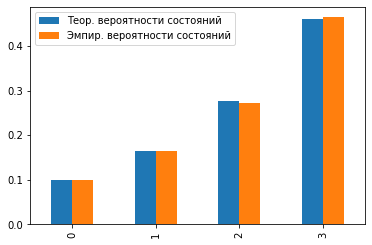

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.180147,0.178700
Вероятность отказа,0.459559,0.463900
Среднее количество заявок в СМО,2.095588,2.100228
Среднее количество заявок в очереди,1.194853,1.200366
Среднее время нахождения заявки в очереди,3.584559,3.601098
Среднее количество используемых каналов,0.900735,0.899862


In [2]:
sim = Simulator(rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/5)
sim.full_compare()

Далее иследуем СМО при различных значениях тех параметров, которые не зафиксированы условием задачи:

Попробуем изменить параметр распределния Эрланга (service_shape). По логике, при его увеличении должно увеличиться среднее время на обслуживание, т.к. распределение Эрланга с параметром k, характеризует время ожидания до того, как в Пуассоновском потоке событие произойдет k раз. Протестируем симуляцией:

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.007146,0.005597
1,0.043673,0.044041
2,0.247037,0.252394
3,0.702144,0.697968


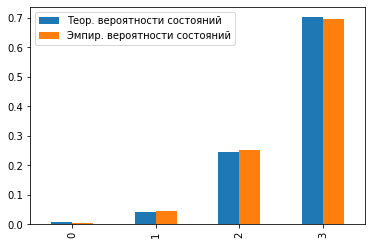

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.099285,0.100677
Вероятность отказа,0.702144,0.697968
Среднее количество заявок в СМО,2.644178,2.642733
Среднее количество заявок в очереди,1.651325,1.648330
Среднее время нахождения заявки в очереди,4.953975,4.944991
Среднее количество используемых каналов,0.992854,0.994403


In [3]:
sim = Simulator(rq_intensity=1/3,
              service_shape=2,
              service_intensity=1/5)
sim.full_compare()

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.000062,0.000134
1,0.003059,0.003692
2,0.146870,0.152685
3,0.850009,0.843488


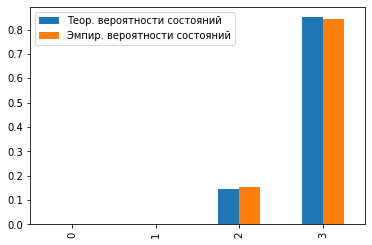

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.049997,0.052171
Вероятность отказа,0.850009,0.843488
Среднее количество заявок в СМО,2.846827,2.839528
Среднее количество заявок в очереди,1.846889,1.839662
Среднее время нахождения заявки в очереди,5.540667,5.518986
Среднее количество используемых каналов,0.999938,0.999866


In [4]:
sim = Simulator(rq_intensity=1/3,
              service_shape=4,
              service_intensity=1/5)
sim.full_compare()

Как можно заметить, вероятности сдвигаются больше в правую сторону, т.е. очередь плотнее заполняется, что и потверждает нашу гипотезу. Далее попробуем увеличить второй параметр закона Эрланга, по сути интенсивность:

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.25,0.244435
1,0.25,0.245426
2,0.25,0.253728
3,0.25,0.256410


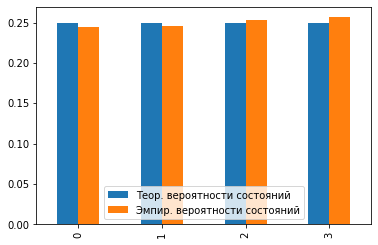

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.25,0.247863
Вероятность отказа,0.25,0.256410
Среднее количество заявок в СМО,1.50,1.522114
Среднее количество заявок в очереди,0.75,0.766549
Среднее время нахождения заявки в очереди,2.25,2.299646
Среднее количество используемых каналов,0.75,0.755565


In [5]:
sim = Simulator(rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/3)
sim.full_compare()

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.415385,0.433505
1,0.276923,0.273422
2,0.184615,0.176611
3,0.123077,0.116463


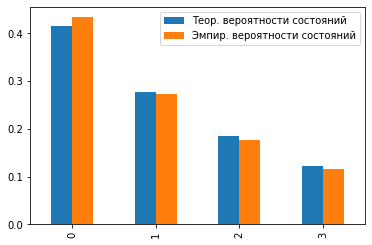

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.292308,0.294512
Вероятность отказа,0.123077,0.116463
Среднее количество заявок в СМО,1.015385,0.976031
Среднее количество заявок в очереди,0.430769,0.409536
Среднее время нахождения заявки в очереди,1.292308,1.228608
Среднее количество используемых каналов,0.584615,0.566495


In [6]:
sim = Simulator(rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/2)
sim.full_compare()

В данном случае, очередь становится более свободной, что логично, так как мы увеличивали интенсивность обслуживания. Далее попробуем увеличить оба параметра одновременно:

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.067862,0.072278
1,0.160229,0.160773
2,0.331192,0.334529
3,0.440717,0.432420


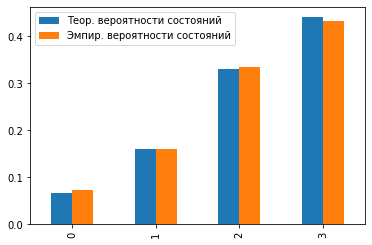

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.186428,0.189193
Вероятность отказа,0.440717,0.432420
Среднее количество заявок в СМО,2.144765,2.127091
Среднее количество заявок в очереди,1.212626,1.199369
Среднее время нахождения заявки в очереди,3.637879,3.598107
Среднее количество используемых каналов,0.932138,0.927722


In [7]:
sim = Simulator(rq_intensity=1/3,
              service_shape=2,
              service_intensity=1/2.5)
sim.full_compare()

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.049649,0.047385
1,0.150329,0.150588
2,0.370232,0.368706
3,0.429790,0.433322


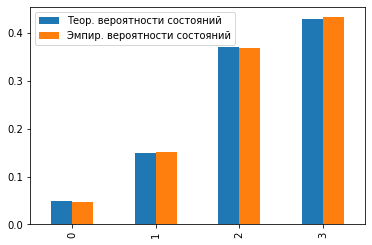

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.190070,0.188893
Вероятность отказа,0.429790,0.433322
Среднее количество заявок в СМО,2.180162,2.187965
Среднее количество заявок в очереди,1.229811,1.235349
Среднее время нахождения заявки в очереди,3.689433,3.706048
Среднее количество используемых каналов,0.950351,0.952615


In [8]:
sim = Simulator(rq_intensity=1/3,
              service_shape=4,
              service_intensity=1/1.25)
sim.full_compare()

В целом, можно наблюдать, что параметры компенсируют друг друга в каком-то смысле, однако первый все-таки имеет больший эффект, так как вероятности немного сдвигаются вправо. Далее попробуем уменшить интенсивность потока заявок:

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.199707,0.190076
1,0.287859,0.281962
2,0.312728,0.317562
3,0.199707,0.210400


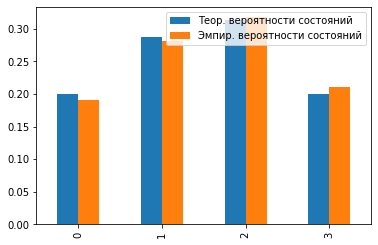

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.160059,0.157920
Вероятность отказа,0.199707,0.210400
Среднее количество заявок в СМО,1.512434,1.548288
Среднее количество заявок в очереди,0.712141,0.738363
Среднее время нахождения заявки в очереди,3.560706,3.691816
Среднее количество используемых каналов,0.800293,0.809924


In [9]:
sim = Simulator(rq_intensity=1/5,
              service_shape=4,
              service_intensity=1/1.25)
sim.full_compare()

Вполне логично, система лучше справляется с обработкой